In [1]:
import clip
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms
from loaders import CxrDataLoader

In [2]:
CHECKPOINT_PATH = "./output/clip_cxr_model.pt"

args = argparse.Namespace(
    dataset_name='iu-xray',
    batch_size=16,
    num_workers=0,
    max_seq_length=248
)

In [3]:
model, preprocess = clip.load(CHECKPOINT_PATH, load_from_clip=False, load_checkpoint=True)

input_resolution = model.visual.input_resolution
context_length = model.context_length
extended_context_length = model.extended_context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Original context length:", context_length)
print("Extended context length:", extended_context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,899,919
Input resolution: 224
Original context length: 248
Extended context length: 248
Vocab size: 49408


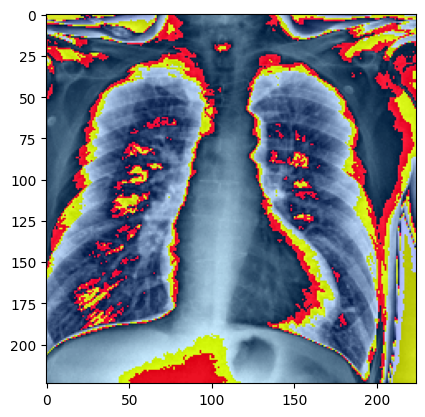

In [4]:
test_loader = CxrDataLoader(args, split='test', transform=preprocess)

test_loader_iter = iter(test_loader)
entry = next(test_loader_iter)

image = transforms.ToPILImage()(entry["image"][0])
image = image.convert("RGB")

plt.imshow(image, cmap="gray")

In [14]:
image_tensor = entry["image"][0].unsqueeze(0)
report = entry["report"][0]

proj_features, image_features = model.encode_image(image_tensor)
text_features = model.encode_text(clip.tokenize(report)).float()

print(f"Image features: {proj_features.shape}")
print(f"Text features: {text_features.shape}")

proj_features /= proj_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.detach().numpy() @ proj_features.detach().numpy().T

with torch.no_grad():
    output = model.predict_medical_concepts(image_features)
    probs = output["probs"]

print(f"Image probs: {probs}")
print(f"Similarity: {similarity}")

Image features: torch.Size([1, 512])
Text features: torch.Size([1, 512])
Image probs: tensor([[0.4534, 0.5166, 0.3993, 0.4881, 0.5057, 0.5233, 0.5129, 0.4811, 0.5414,
         0.4513, 0.4778, 0.4575, 0.4271, 0.5005]])
Similarity: [[0.2622522]]
